In [1]:
import os
from time import time
import multiprocessing
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas

In [2]:
# ds_stream = xr.open_dataset('data/processed/stream-pd-int2.nc')
ds_stream_mean = xr.open_dataset('data/processed/stream-mean-power3.nc')
search = xr.open_dataset('data/processed/stream-search-space.nc')

space = search.space.values
ds_stream_mean

<xarray.Dataset>
Dimensions:  (lat: 519, lon: 232)
Coordinates:
  * lat      (lat) float32 48.0 48.03 48.05 48.08 ... 61.92 61.95 61.97 62.0
  * lon      (lon) float32 -10.0 -9.939 -9.879 -9.818 ... 3.818 3.879 3.939 4.0
Data variables:
    power    (lat, lon) float64 ...

In [3]:
power_space = np.zeros((len(ds_stream_mean.lat.values),len(ds_stream_mean.lon.values)))
power_space[:] = np.nan

for j in range(len(ds_stream_mean.lat.values)):
    for k in range(len(ds_stream_mean.lon.values)):
        if np.isnan(space[j,k]) == True:
            pass
        elif space[j,k] == 0:
            power_space[j,k] = -10
        else: 
            power_space[j,k] = ds_stream_mean.power.values[j,k]

In [4]:
pow_xr = xr.Dataset({
    'power': xr.DataArray(
        data=power_space,
        coords={'lat': ds_stream_mean.lat.values,
                'lon': ds_stream_mean.lon.values},
        dims=['lat','lon'])})


pow_xr['power'] = pow_xr.power.assign_attrs(units='W')
pow_xr['power'] = pow_xr.power.assign_attrs(long_name='mean power')
pow_xr['lat'] = pow_xr.lat.assign_attrs(units='degrees')
pow_xr['lat'] = pow_xr.lat.assign_attrs(long_name='latitude')
pow_xr['lon'] = pow_xr.lon.assign_attrs(units='degrees')
pow_xr['lon'] = pow_xr.lon.assign_attrs(long_name='longitude')

pow_xr.to_netcdf(path=f'data/processed/stream-static-meanpow-space1.nc')

In [5]:
ds = xr.open_dataset('data/processed/stream-static-meanpow-space1.nc')

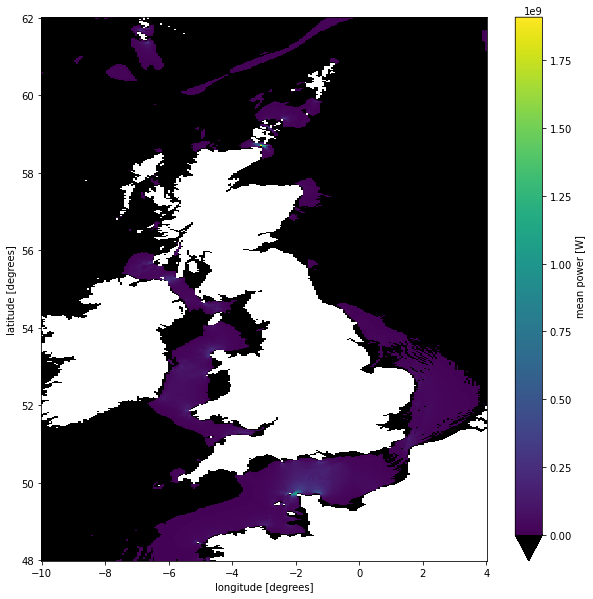

In [6]:
cmap = mpl.cm.get_cmap('viridis').copy()
cmap.set_under('black')

ds.power.plot(size=10,aspect=1,vmin=0,cmap=cmap)  

In [1]:
from turningpointsstream import *

In [2]:
ds_stream = xr.open_dataset('data/processed/stream-pd-int2.nc')

In [3]:
pd = ds_stream.pd.values

t = ds_stream.time.values 
latitude = ds_stream.lat.values
longitude = ds_stream.lon.values


In [4]:
idx_peaks,_,__ = peak_trough_idx(pd,t,latitude,longitude) 

In [5]:
idx_peaks.shape

(108, 519, 232)

In [6]:
first_peak = idx_peaks[0,:,:]

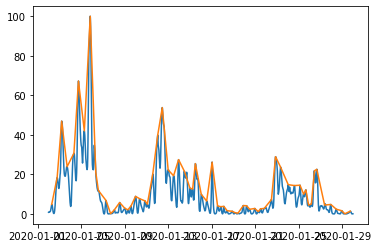

In [7]:
test = idx_peaks[:,500,20][idx_peaks[:,500,20]<=len(t)].astype('int')
plt.figure()
plt.plot(t,pd[:,500,20])
plt.plot(t[test],pd[test,500,20])

In [8]:
secs = (t-epoch)/1e9 # dtype is timedelta[s] not timedelta[ns]
secs = secs.astype('float64')
secs = secs - secs[0]
phase = (secs/T)*2*np.pi
phase = phase%(2*np.pi)

In [16]:
phase_peak = np.zeros((len(ds_stream.lat.values),len(ds_stream.lon.values)))
phase_peak[:] = np.nan

for j in range(len(ds_stream.lat.values)):
    for k in range(len(ds_stream.lon.values)):
        if pd[0,j,k] < 0:
            phase_peak[j,k] = pd[0,j,k]
        if np.isnan(first_peak[j,k]) == True:
            pass
        else: 
            phase_peak[j,k] = phase[int(first_peak[j,k])]

In [17]:
phase_peak.shape

(519, 232)

In [18]:
phase_xr = xr.Dataset({
    'phase': xr.DataArray(
        data=phase_peak,
        coords={'lat': ds_stream.lat.values,
                'lon': ds_stream.lon.values},
        dims=['lat','lon'])})


phase_xr['phase'] = phase_xr.phase.assign_attrs(units='radians')
phase_xr['phase'] = phase_xr.phase.assign_attrs(long_name='power phase difference relative to 2020-01-02T00:00:00')
phase_xr['lat'] = phase_xr.lat.assign_attrs(units='degrees')
phase_xr['lat'] = phase_xr.lat.assign_attrs(long_name='latitude')
phase_xr['lon'] = phase_xr.lon.assign_attrs(units='degrees')
phase_xr['lon'] = phase_xr.lon.assign_attrs(long_name='longitude')

phase_xr.to_netcdf(path=f'data/processed/stream-static-powerphase1.nc')

In [19]:
ds = xr.open_dataset('data/processed/stream-static-powerphase1.nc')

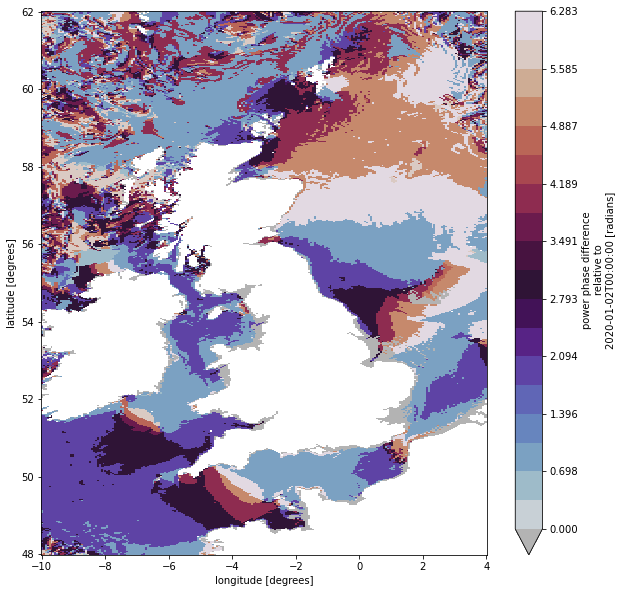

In [23]:
cmap = mpl.cm.get_cmap('twilight').copy()
cmap.set_bad('white')
cmap.set_under('#b3b3b3')

ds.phase.plot(size=10,aspect=1,levels=19,vmin=0,vmax=2*np.pi,cmap=cmap)  

# plt.savefig('figures/for-report/stream-phase-map.png')